In [ ]:
import argparse
import os
import random
import torch as t
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision as tv
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#TODO: make resnet from noise to decision layers

In [2]:
manualSeed = 42
print("Random seed = ", manualSeed)
random.seed(manualSeed)
t.manual_seed(manualSeed)

Random seed =  42


In [3]:
dataroot = './data/celeba'
num_workers = 2
batch_size=64
image_size=64

nc = 3 #no. channels of images
nz = 100
ngf = 64 #no. generator's feature maps
ndf = 64 #no. discriminator's feature maps
num_epochs = 5
lr = .0002
beta1 = .5
ngpu = 1 #no. gpu


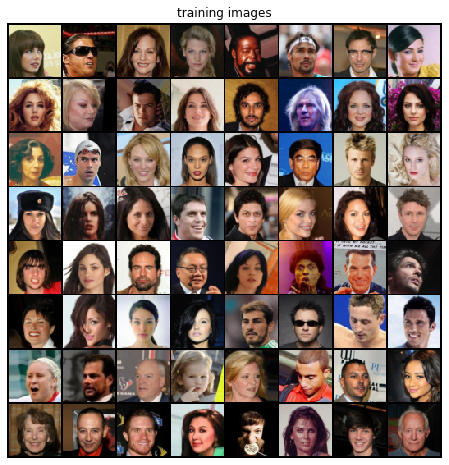

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

dataset = tv.datasets.ImageFolder(root=dataroot,
                                 transform=tv.transforms.Compose([
                                     tv.transforms.Resize(image_size), 
                                     tv.transforms.RandomHorizontalFlip(p=0.5),
                                     tv.transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),\
                                     tv.transforms.RandomAffine(0, scale=(.95, 1.2)), \
                                     tv.transforms.CenterCrop(image_size),
                                     tv.transforms.ToTensor(),
                                     tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5)), 
                                     AddGaussianNoise(.5, .05),
                                 ]))
dataset = tv.datasets.ImageFolder(root=dataroot,
                           transform=tv.transforms.Compose([
                               tv.transforms.Resize(image_size),
                               tv.transforms.CenterCrop(image_size),
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader2 = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

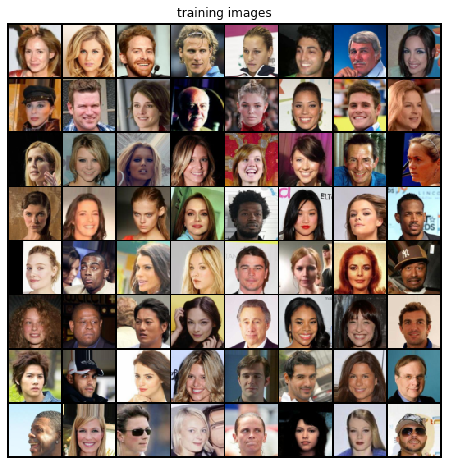

In [5]:
real_batch = next(iter(dataloader2))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [6]:
#now, init model weight according to normal distribution, why?
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        t.nn.init.normal_(m.weight.data, .0, .02)
    elif classname.find('BatchNorm')!= -1:
        t.nn.init.normal_(m.weight.data, 1.0, .02)
        t.nn.init.constant_(m.bias.data, 0.0)

In [22]:
class Generator(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ngf * 8)
        self.res1 = t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.res_bn1 = t.nn.BatchNorm2d(ngf * 8)
        
        self.conv2 = t.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ngf * 4)
        self.res2 = t.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.res2_bn = t.nn.BatchNorm2d(ngf * 4)        

        self.conv3 = t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ngf * 2)
        self.res3 = t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.res3_bn = t.nn.BatchNorm2d(ngf * 2)
        self.bridge = t.nn.ConvTranspose2d( ngf * 4, int(ngf*1), 6, 4, 1, bias=False)
        self.bridge_bn = t.nn.BatchNorm2d(int(ngf*1))   
        
        self.conv4 = t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ngf * 1)
        self.res4 = t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.res4_bn = t.nn.BatchNorm2d(ngf * 1)

        
        self.conv5 = t.nn.ConvTranspose2d( ngf, int(ngf * .5), 4, 2, 1, bias=False)
        self.bn5 = t.nn.BatchNorm2d(int(ngf * .5))
        self.res5 = t.nn.ConvTranspose2d( ngf, int(ngf * .5), 3, 2, 1, bias=False)
        self.res5_bn = t.nn.BatchNorm2d(int(ngf * .5))       

        
        self.conv6 = t.nn.ConvTranspose2d( int(ngf * .5), nc, 3, 1, 1, bias=False)
        
    def freeze(self):
        for param in model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = t.nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        res = self.res2_bn(self.res2(x))
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = x + res
        res = self.res3_bn(self.res3(x))
        bridge = self.bridge_bn(self.bridge(x))
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x + res
        res = self.res4_bn(self.res4(x))       
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = x + res
        res = self.res5_bn(self.res5(x))  
        x = t.nn.functional.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.2)
        flow = x
        x = t.tanh(self.conv6(x))
        return x, flow, bridge

class GeneratorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is Z, going into a convolution
            t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            t.nn.BatchNorm2d(ngf * 8),
            t.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            t.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 4),
            t.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 2),
            t.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf),
            t.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            t.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [23]:
netg = Generator(ngpu).to(device)
if (device.type=='cuda') and (ngpu > 1):
    netg = t.nn.DataParallel(netg, list(range(ngpu)))
netg.apply(weight_init)  #apply weight_init recursively to all children
print(netg)

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (res_bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (res2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2

In [24]:
for item in netg.children():
    for item2 in item.children():
        print (item2.__class__.__name__)


In [29]:
class Discriminator(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = t.nn.Conv2d(nc * 2, ndf * 1, 4, stride=2, padding=1, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ndf * 1)   

        self.conv2 = t.nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ndf * 2)
        self.res2 = t.nn.Conv2d(ndf, ndf * 2, 1, stride=2, padding=0, bias=False)
        self.res2_bn = t.nn.BatchNorm2d(ndf * 2)          
        
        self.conv3 = t.nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ndf * 4)
        self.res3 = t.nn.Conv2d(ndf * 2, ndf * 4, 1, stride=2, padding=0, bias=False)
        self.res3_bn = t.nn.BatchNorm2d(ndf * 4)        
        
        self.conv4 = t.nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ndf * 8)
        self.res4 = t.nn.Conv2d(ndf * 4, ndf * 8, 1, stride=2, padding=0, bias=False)
        self.res4_bn = t.nn.BatchNorm2d(ndf * 8)        
        
        self.conv5 = t.nn.Conv2d(ndf * 8, ndf * 8, 4, stride=1, padding=1, bias=False)
        self.bn5 = t.nn.BatchNorm2d(ndf * 8)
        self.aapool1 = t.nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = t.nn.Linear(ndf * 8, 1)        

    def forward(self, x1, x2, flow, bridge):
        #print (x1.shape, x2.shape, flow.shape)
        x = t.cat((x1, x2), dim=1)
        x = t.nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        #print (x.shape, bridge.shape)
        x = x + bridge
        res = self.res2_bn(self.res2(x))
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = x + res
        res = self.res3_bn(self.res3(x))        
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x + res
        res = self.res4_bn(self.res4(x))           
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.2)
        #x = t.sigmoid(self.conv5(x))
        x = self.aapool1(x).squeeze()
        x = t.sigmoid(self.fc1(x))        
        return x

class DiscriminatorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is (nc) x 64 x 64
            t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 2),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 4),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 8),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            t.nn.S ()
        )

    def forward(self, input):
        return self.main(input)

In [30]:
netd = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netd = t.nn.DataParallel(netd, list(range(ngpu)))
netd.apply(weight_init)
print(netd)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (res2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res3): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (res3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(

In [31]:
criterion = t.nn.BCELoss()
#criterion = t.nn.BCEWithLogitsLoss()

fixed_noise = t.randn(64, nz, 1, 1, device=device)

label_real = 1
label_fake = 0

optimizer_d = optim.Adam(netd.parameters(), lr=lr, betas=(beta1, .999))
optimizer_g = optim.Adam(netg.parameters(), lr=lr, betas=(beta1, .999))


In [ ]:
num_epochs = 20

img_list = []
g_loss = []
d_loss = []
iters = 0

print ('Start training')

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netd.zero_grad()
        
        #train d
        #train d with all read data batch
        real_cpu = data[0].to(device)
        real_cpu2 = next(iter(dataloader2))[0].to(device)
        b_size = np.min((real_cpu.size(0), real_cpu2.size(0)))
        real_cpu = real_cpu[:b_size]
        real_cpu2 = real_cpu2[:b_size]   
        
        noise = t.randn(b_size, nz, 1, 1, device=device)
        fake, flow, bridge = netg(noise)
        
        label = t.full((b_size,), label_real, dtype=t.float, device=device) #create a vector [label_real, ...] equal to batch size

        #label.fill_(label_real)
        output = netd(real_cpu, real_cpu2, flow.detach(),bridge.detach()).view(-1)
        err_d_real = criterion(output, label)
        err_d_real.backward()
        D_x = output.mean().item() #why mean here? mean over all batch values?
        
        label.fill_(label_fake) #change the gt label, no be [label_fake, ...] instead
        output = netd(real_cpu, fake.detach(), flow.detach(), bridge.detach()).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()
        D_G_z1 = output.mean().item() #D(G(z)) over batch of z        
        
        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()
        
        #train g: minimize 1 - D(G(z)) is maximize (D(G(z)))
        netg.zero_grad()
        label.fill_(label_real)
        output=netd(real_cpu, fake, flow, bridge).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()
        
        if i%50 == 0:
            print (f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \t Loss_D: {err_d.item():.4f}, Loss_G: {err_g.item():.4f} \t D(x): {D_x} \t D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        
        g_loss.append(err_g.item())
        d_loss.append(err_d.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with t.no_grad():
                fake = netg(fixed_noise)[0].detach().cpu()
            img_list.append(tv.utils.make_grid(fake, padding=2, normalize=True))    
            
        iters += 1#fine grain iteration 

Start training
[0/20][0/3166] 	 Loss_D: 1.0863, Loss_G: 1.3036 	 D(x): 0.5794732570648193 	 D(G(z)): 0.3764 / 0.2835


In [ ]:
real_cpu.shape, fake.shape

In [ ]:

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128


plt.figure(figsize=(10, 5))
plt.title('generator & discriminator loss')
plt.plot(g_loss, label='G')
plt.plot(d_loss, label='D')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.tight_layout()
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('real images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('fake images')
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))


In [ ]:
output.shape, label.shape, real_cpu.shape